This notebook provides statistics on the results of our book clustering.


## Setup


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Load Data

Let's start by getting our clusters and their statistics:


In [2]:
clusters = pd.read_parquet('book-links/cluster-stats.parquet')
clusters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39732662 entries, 0 to 39732661
Data columns (total 8 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   cluster        int32 
 1   n_nodes        uint32
 2   n_isbns        uint32
 3   n_loc_recs     uint32
 4   n_ol_editions  uint32
 5   n_ol_works     uint32
 6   n_gr_books     uint32
 7   n_gr_works     uint32
dtypes: int32(1), uint32(7)
memory usage: 1.2 GB


In [3]:
clusters.set_index('cluster', inplace=True)

Describe the count columns for basic descriptive stats:


In [4]:
clusters.describe()

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
count,3.973266e+07,3.973266e+07,3.973266e+07,3.973266e+07,3.973266e+07,3.973266e+07,3.973266e+07
mean,3.376026e+00,1.081715e+00,2.433912e-01,1.129079e+00,8.241216e-01,5.941346e-02,3.830506e-02
std,1.797330e+01,8.757449e+00,5.499364e-01,7.460525e+00,6.720492e-01,1.386907e+00,2.057899e-01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
50%,3.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
75%,4.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
max,9.998300e+04,4.785700e+04,1.560000e+03,4.164800e+04,2.368000e+03,7.289000e+03,3.260000e+02


75% of clusters only contain 2 ISBNs (probably -10 and -13) and one book. OpenLibrary also contributes to the largest number of clusters.

## Clusters per Source

How many clusters are connected to each source?


In [5]:
src_counts = pd.Series(dict(
    (c, np.sum(clusters[c] > 0)) for c in clusters.columns
))
src_counts

n_nodes          39732662
n_isbns          23191293
n_loc_recs        9279082
n_ol_editions    33194439
n_ol_works       31327564
n_gr_books        1505314
n_gr_works        1504790
dtype: int64

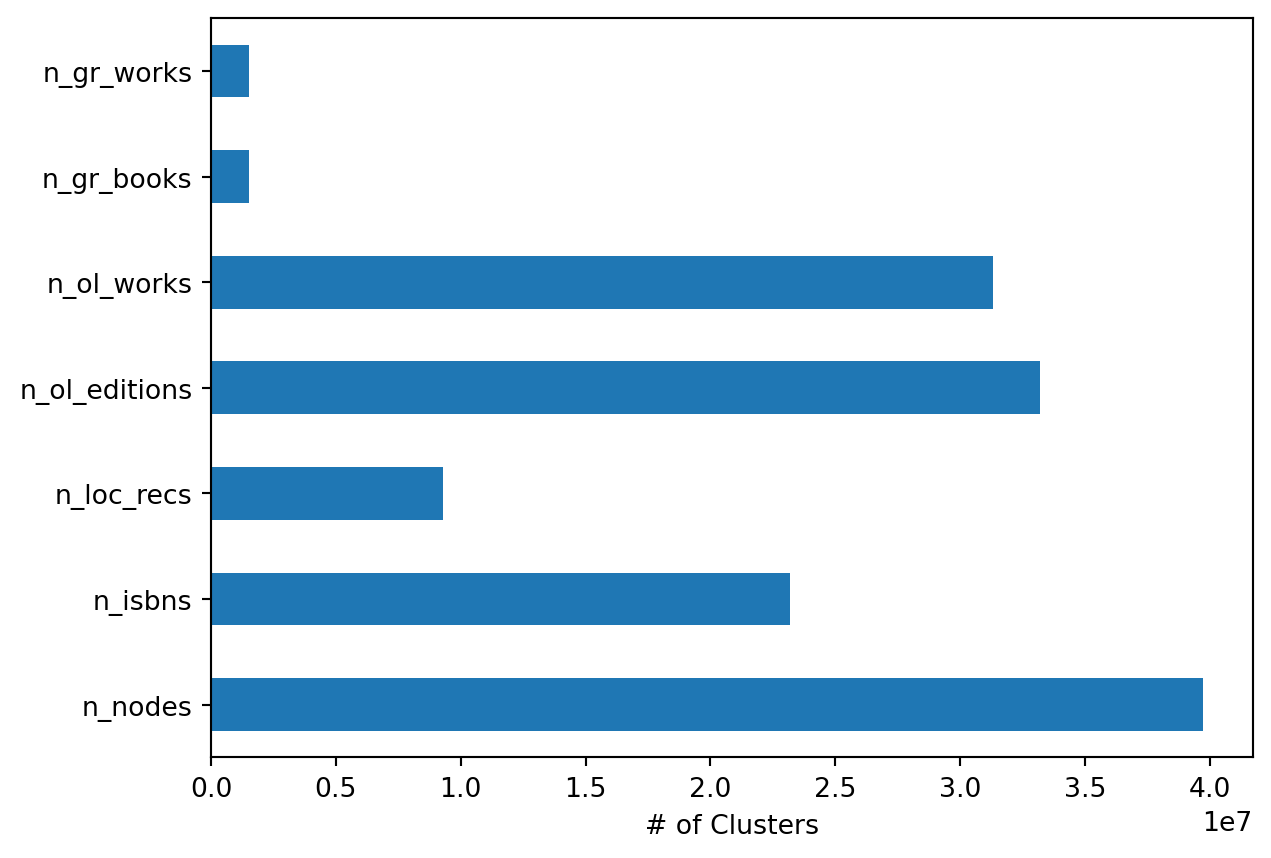

In [6]:
src_counts.plot.barh()
plt.xlabel('# of Clusters')
plt.show()

## Distributions

Let's look at the distributions of cluster sizes.


In [7]:
size_dist = pd.concat(dict(
    (c, clusters[c].value_counts()) for c in clusters.columns if c != 'n_nodes'
), names=['RecType'])
size_dist.index.set_names(['RecType', 'RecCount'], inplace=True)
size_dist = size_dist.reset_index(name='Clusters')
size_dist.head()

,RecType,RecCount,Clusters
0,n_isbns,0,16541369
1,n_isbns,1,11554892
2,n_isbns,2,9211321
3,n_isbns,4,833453
4,n_isbns,3,790629


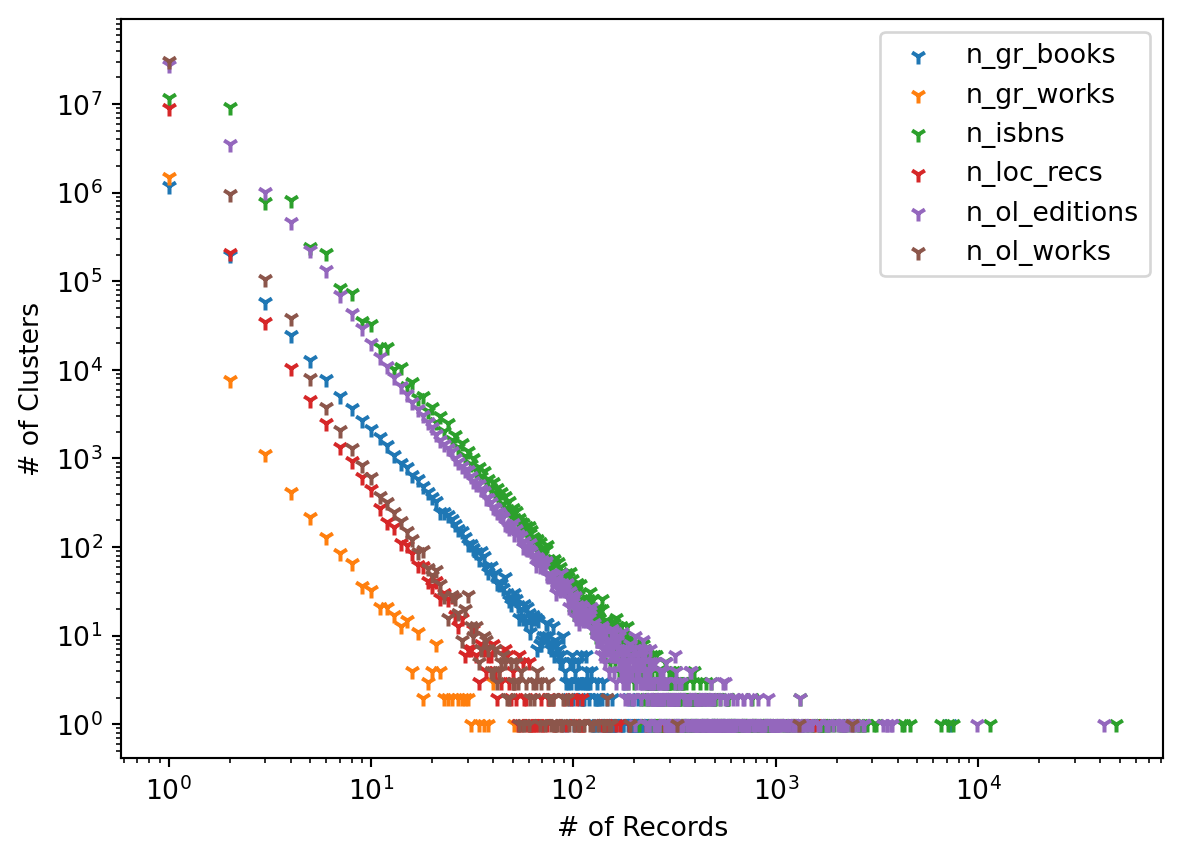

In [8]:
for rt, data in size_dist.groupby('RecType'):
    plt.scatter(data['RecCount'], data['Clusters'], marker='1', label=rt)
plt.legend()
plt.xlabel('# of Records')
plt.xscale('log')
plt.ylabel('# of Clusters')
plt.yscale('log')
plt.show()

Looks mostly fine - we expect a lot of power laws - but the number of clusters with merged GoodReads works is concerning.

## GoodReads Work Merging

Why are GoodReads works merging? Let's look at those.


In [9]:
gr_big = clusters[clusters['n_gr_works'] > 1].sort_values('n_gr_works', ascending=False)
gr_big.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9947 entries, 100007751 to 123687437
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   n_nodes        9947 non-null   uint32
 1   n_isbns        9947 non-null   uint32
 2   n_loc_recs     9947 non-null   uint32
 3   n_ol_editions  9947 non-null   uint32
 4   n_ol_works     9947 non-null   uint32
 5   n_gr_books     9947 non-null   uint32
 6   n_gr_works     9947 non-null   uint32
dtypes: uint32(7)
memory usage: 349.7 KB


We have a lot of these clusters. What fraction of the GoodReads-affected clusters is this?


In [10]:
len(gr_big) / clusters['n_gr_books'].count()

0.0002503481896078345

Less than 1%. Not bad, but let's look.


In [11]:
gr_big.head()

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
cluster,,,,,,,
100007751,99983,47857,1560,41648,1303,7289,326
100121298,9562,4627,281,3710,323,515,106
100280224,513,192,6,110,75,69,61
100758802,1548,749,54,442,80,170,53
103061864,315,141,1,51,18,53,51


## Large Cluster Debugging

We have some pretty big clusters:


In [12]:
big = clusters.nlargest(5, 'n_nodes')
big

,n_nodes,n_isbns,n_loc_recs,n_ol_editions,n_ol_works,n_gr_books,n_gr_works
cluster,,,,,,,
100007751,99983,47857,1560,41648,1303,7289,326
100241120,23061,11497,189,9899,95,1353,28
124319853,11281,7520,0,3760,1,0,0
122565397,10678,7118,0,3559,1,0,0
100386149,10118,6518,7,3558,35,0,0


What is up with this? We should figure out what went wrong, if we can.  What are its ISBNs?


In [13]:
isbns = pd.read_parquet('book-links/all-isbns.parquet').set_index('isbn_id')
isbns.head()

,isbn,AZ18,LOC,OL,GR,BX,AZ14
isbn_id,,,,,,,
1,0001713353,54,0,1,1,0,0
2,0001061240,45,0,1,1,0,0
3,0001932349,18,0,1,0,0,0
4,0001712799,54,0,2,0,0,0
5,0002006448,18,0,1,0,0,0


In [14]:
links = pd.read_parquet('book-links/isbn-clusters.parquet', columns=['isbn_id', 'cluster'])
links.head()

,isbn_id,cluster
0,42979427,942979427
1,42979426,942979426
2,42979425,942979425
3,42979424,942979424
4,42979423,942979423


In [15]:
big_id = big.index[0]
bl = links[links['cluster'] == big_id].drop(columns=['cluster'])
bl = bl.join(isbns, on='isbn_id')
bl.sort_values('isbn')

,isbn_id,isbn,AZ18,LOC,OL,GR,BX,AZ14
42976118,41134263,0000744395,0,0,0,1,0,0
42971344,41072568,000074445X,0,0,0,1,0,0
42957835,35505305,0001004735,0,0,1,0,0,0
42938741,27575974,0001004743,0,0,1,0,0,0
42964480,18407128,0001034375,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...
42932718,42155818,B073SM1DVP,0,0,0,1,0,0
42931570,42232335,B073SMQ7TV,0,0,0,1,0,0
42954797,42257427,B074P9CM5T,0,0,0,1,0,0
42948411,42225949,B074WFRH82,0,0,0,1,0,0


What are the things with the highest record count (besides ratings)?


In [16]:
bl['btot'] = bl.iloc[:, 2:-2].sum(axis=1)
bl.nlargest(20, 'btot')

,isbn_id,isbn,AZ18,LOC,OL,GR,BX,AZ14,btot
42928900,34969,0140434186,7624,1,2,1,23,0,7628
42963765,35800,0140861750,4544,0,1,0,0,0,4545
42946763,379,0003302245,3900,0,1,0,0,0,3901
42969091,1921,000735083X,3896,0,0,1,0,0,3897
42939448,35259,0140437681,3021,1,1,1,2,0,3024
42938409,1938,0007350856,2724,0,0,1,0,0,2725
42931727,35096,0140441077,1608,0,5,1,25,0,1614
42952278,34698,0140366679,1591,0,1,1,14,276,1593
42951250,34710,0140350136,1460,0,2,1,3,0,1463
42965982,870,0007119313,1373,0,1,1,0,0,1375
